## PPC

In [1]:
import sys
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import sparse

sns.set(context="notebook", font_scale=1.3, style="ticks")
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=False

sys.path.append("../utils/")
from totalppc import TotalPosteriorPredictiveCheck as totalPPC
from scvi import set_seed

# colors = ["#9b59b6", "#3498db", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]
# colors_3 = ["#9b59b6", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
colors_3 = ["#3B7EA1", "#D9661F", "#859438", "#EE1F60", "#00A598"]

set_seed(0)

In [2]:
anndataset_pbmc = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")
anndataset_malt = anndata.read(save_path + "malt_10k_protein_v3.h5ad")
anndataset_sln = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_sln = anndataset_sln[anndataset_sln.obs["batch_indices"] == 0]

In [3]:
dataset_pbmc = AnnDatasetFromAnnData(ad=anndataset_pbmc)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_pbmc.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_pbmc.uns["protein_names"],
)
dataset_pbmc.initialize_cell_measurement(protein_data)

dataset_malt = AnnDatasetFromAnnData(ad=anndataset_malt)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_malt.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_malt.uns["protein_names"],
)
dataset_malt.initialize_cell_measurement(protein_data)

# Removes HTOs
dataset_sln = AnnDatasetFromAnnData(ad=anndataset_sln)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_sln.obsm["protein_expression"][:, :-2].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_sln.uns["protein_names"][:-2],
)
dataset_sln.initialize_cell_measurement(protein_data)

datasets = [dataset_pbmc, dataset_malt, dataset_sln]

[2020-05-06 17:31:59,970] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-06 17:31:59,973] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-06 17:32:00,159] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 17:32:00,345] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-05-06 17:32:00,751] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-06 17:32:00,753] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-06 17:32:00,936] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 17:32:01,119] INFO - scvi.dataset.dataset | Downsampled from 6838 to 6838 cells
[2020-05-06 17:32:01,567] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-06 17:32:01,572] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-06 17:32:01,785] INFO - scvi.dataset.dataset | Computing the library size for the new data
[20

In [4]:
for d in datasets:
    d.update_genes(d.var["highly_variable"])

[2020-05-06 17:32:03,164] INFO - scvi.dataset.dataset | Downsampling from 16727 to 4000 genes
[2020-05-06 17:32:03,286] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 17:32:03,395] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-05-06 17:32:03,488] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 17:32:03,535] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-05-06 17:32:03,537] INFO - scvi.dataset.dataset | Downsampling from 16659 to 4000 genes
[2020-05-06 17:32:03,658] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 17:32:03,734] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-05-06 17:32:03,809] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-06 17:32:03,857] INFO - scvi.dataset.dataset | Downsampled from 6838 to 6838 cells
[2020-05-06 17:32:03,859] INFO - scvi.dataset.datase

In [5]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [6]:
vae_pbmc = TOTALVI(dataset_pbmc.nb_genes, len(dataset_pbmc.protein_names))
vae_malt = TOTALVI(dataset_malt.nb_genes, len(dataset_malt.protein_names))
vae_sln = TOTALVI(dataset_sln.nb_genes, len(dataset_sln.protein_names))


trainer_pbmc = TotalTrainer(
    vae_pbmc,
    dataset_pbmc,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256},
    early_stopping_kwargs=early_stopping_kwargs,
)

trainer_malt = TotalTrainer(
    vae_malt,
    dataset_malt,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256},
    early_stopping_kwargs=early_stopping_kwargs,
)

trainer_sln = TotalTrainer(
    vae_sln,
    dataset_sln,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256},
    early_stopping_kwargs=early_stopping_kwargs,
)

In [7]:
scvi_pbmc = VAE(dataset_pbmc.nb_genes, n_latent=20, reconstruction_loss="nb")
scvi_malt = VAE(dataset_malt.nb_genes, n_latent=20, reconstruction_loss="nb")
scvi_sln = VAE(dataset_sln.nb_genes, n_latent=20, reconstruction_loss="nb")

scvi_trainer_pbmc = UnsupervisedTrainer(
    scvi_pbmc,
    dataset_pbmc,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=10,
)

scvi_trainer_malt = UnsupervisedTrainer(
    scvi_malt,
    dataset_malt,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=10,
)

scvi_trainer_sln = UnsupervisedTrainer(
    scvi_sln,
    dataset_sln,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=10,
)

In [8]:
if overwrite is True:
    trainer_pbmc.train(lr=lr, n_epochs=500)
    torch.save(trainer_pbmc.model.state_dict(), "saved_models/pbmc10k_ppc.pt")
    trainer_malt.train(lr=lr, n_epochs=500)
    torch.save(trainer_malt.model.state_dict(), "saved_models/malt_ppc.pt")
    trainer_sln.train(lr=lr, n_epochs=500)
    torch.save(trainer_sln.model.state_dict(), "saved_models/sln_ppc.pt")
    scvi_trainer_pbmc.train(lr=2e-3, n_epochs=500)
    torch.save(scvi_trainer_pbmc.model.state_dict(), "saved_models/scvi_pbmc10k_ppc.pt")
    scvi_trainer_malt.train(lr=2e-3, n_epochs=500)
    torch.save(scvi_trainer_malt.model.state_dict(), "saved_models/scvi_malt_ppc.pt")
    scvi_trainer_sln.train(lr=2e-3, n_epochs=500)
    torch.save(scvi_trainer_sln.model.state_dict(), "saved_models/scvi_sln_ppc.pt")
else:
    # totalVI
    try:
        vae_pbmc.load_state_dict(torch.load("saved_models/pbmc10k_ppc.pt"))
        vae_pbmc.eval()
    except FileNotFoundError:
        trainer_pbmc.train(lr=lr, n_epochs=500)
        torch.save(trainer_pbmc.model.state_dict(), "saved_models/pbmc10k_ppc.pt")
    try:
        vae_malt.load_state_dict(torch.load("saved_models/malt_ppc.pt"))
        vae_malt.eval()
    except FileNotFoundError:
        trainer_malt.train(lr=lr, n_epochs=500)
        torch.save(trainer_malt.model.state_dict(), "saved_models/malt_ppc.pt")
    try:
        vae_sln.load_state_dict(torch.load("saved_models/sln_ppc.pt"))
        vae_sln.eval()
    except FileNotFoundError:
        trainer_sln.train(lr=lr, n_epochs=500)
        torch.save(trainer_sln.model.state_dict(), "saved_models/sln_ppc.pt")
    # scVI
    try:
        scvi_pbmc.load_state_dict(torch.load("saved_models/scvi_pbmc10k_ppc.pt"))
        scvi_pbmc.eval()
    except FileNotFoundError:
        scvi_trainer_pbmc.train(lr=lr, n_epochs=500)
        torch.save(scvi_trainer_pbmc.model.state_dict(), "saved_models/scvi_pbmc10k_ppc.pt")
    try:
        scvi_malt.load_state_dict(torch.load("saved_models/scvi_malt_ppc.pt"))
        scvi_malt.eval()
    except FileNotFoundError:
        scvi_trainer_malt.train(lr=lr, n_epochs=500)
        torch.save(scvi_trainer_malt.model.state_dict(), "saved_models/scvi_malt_ppc.pt")
    try:
        scvi_sln.load_state_dict(torch.load("saved_models/scvi_sln_ppc.pt"))
        scvi_sln.eval()
    except FileNotFoundError:
        scvi_trainer_sln.train(lr=2e-3, n_epochs=500)
        torch.save(scvi_trainer_sln.model.state_dict(), "saved_models/scvi_sln_ppc.pt")

In [9]:
post_pbmc = trainer_pbmc.train_set

full_data_pbmc = np.concatenate(
    [dataset_pbmc.X, dataset_pbmc.protein_expression], axis=1
)

post_malt = trainer_malt.train_set

full_data_malt = np.concatenate(
    [dataset_malt.X, dataset_malt.protein_expression], axis=1
)

post_sln = trainer_sln.train_set

full_data_sln = np.concatenate(
    [dataset_sln.X, dataset_sln.protein_expression], axis=1
)

scvi_post_pbmc = scvi_trainer_pbmc.train_set
scvi_post_malt = scvi_trainer_malt.train_set
scvi_post_sln = scvi_trainer_sln.train_set

In [10]:
ppc_held_pbmc = totalPPC(
    posteriors_dict={"totalVI": trainer_pbmc.validation_set},
    scvi_posts_dict={"scVI": scvi_trainer_pbmc.validation_set},
    n_samples=150,
)
ppc_full_pbmc = totalPPC(
    posteriors_dict={"totalVI": post_pbmc},
    scvi_posts_dict={"scVI": scvi_post_pbmc},
    n_samples=25,
)
ppc_held_malt = totalPPC(
    posteriors_dict={"totalVI": trainer_malt.validation_set},
    scvi_posts_dict={"scVI": scvi_trainer_malt.validation_set},
    n_samples=150,
)
ppc_full_malt = totalPPC(
    posteriors_dict={"totalVI": post_malt},
    scvi_posts_dict={"scVI": scvi_post_malt},
    n_samples=25,
)

ppc_held_sln = totalPPC(
    posteriors_dict={"totalVI": trainer_sln.validation_set},
    scvi_posts_dict={"scVI": scvi_trainer_sln.validation_set},
    n_samples=150,
)
ppc_full_sln = totalPPC(
    posteriors_dict={"totalVI": post_sln},
    scvi_posts_dict={"scVI": scvi_post_sln},
    n_samples=25,
)

In [11]:
ppc_helds = [ppc_held_pbmc, ppc_held_malt, ppc_held_sln]
full_datas = [full_data_pbmc, full_data_malt, full_data_sln]
trainers = [trainer_pbmc, trainer_malt, trainer_sln]

for p, fd, trainer in zip(ppc_helds, full_datas, trainers):
    train_indices = trainer.train_set.indices
    test_indices = trainer.validation_set.indices
    train_data = fd[trainer.train_set.indices]
    p.store_fa_samples(
        train_data,
        train_indices,
        test_indices,
        n_components=vae_pbmc.n_latent,
        normalization="log_rate",
        key="FA"
    )
    p.store_fa_samples(
        train_data,
        train_indices,
        test_indices,
        n_components=vae_pbmc.n_latent,
        normalization="log",
        key="FA",
    )

In [12]:
for p in ppc_helds:
    p.mean_absolute_error()

In [13]:
for p in ppc_helds:
    print(p.metrics["mean_ae"])

             totalVI      scVI  FA (Log Rate)    FA (Log)
genes       0.195570  0.197502       0.242393    0.235229
proteins  153.552155       NaN     162.163132  272.873444
             totalVI      scVI  FA (Log Rate)    FA (Log)
genes       0.210987  0.205664       0.257433    0.263614
proteins  110.390388       NaN     129.142426  258.587341
           totalVI      scVI  FA (Log Rate)   FA (Log)
genes     0.251606  0.257085       0.292002   0.301272
proteins  8.038754       NaN       9.864914  11.306675


In [14]:
for p in ppc_helds:
    p.calibration_error(confidence_intervals=[0.5, 99.5])

In [15]:
ppc_held_pbmc.metrics["calibration"]

,totalVI,scVI,FA (Log Rate),FA (Log)
genes,0.000038,0.000039,0.000442,0.000551
proteins,0.000028,NaN,0.000191,0.000307
total,0.000038,NaN,0.000440,0.000550


In [16]:
def ppc_bar_plots(key="mean_ae"):
    cols = ["totalVI", "scVI", "FA (Log Rate)", "FA (Log)"]
    fig, ax = plt.subplots(2, 2, figsize=(9, 9))
    mae_genes = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    mae_genes.loc["PBMC", :] = np.sqrt(ppc_held_pbmc.metrics[key].loc["genes"])
    mae_genes.loc["MALT", :] = np.sqrt(ppc_held_malt.metrics[key].loc["genes"])
    mae_genes.loc["SLN111-D1", :] = np.sqrt(ppc_held_malt.metrics[key].loc["genes"])
    mae_proteins = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    mae_proteins.loc["PBMC", :] = np.sqrt(ppc_held_pbmc.metrics["mean_ae"].loc["proteins"])
    mae_proteins.loc["MALT", :] = np.sqrt(ppc_held_malt.metrics["mean_ae"].loc["proteins"])
    mae_proteins.loc["SLN111-D1", :] = np.sqrt(ppc_held_malt.metrics["mean_ae"].loc["proteins"])


    mae_genes[cols].plot(kind="bar", ax=ax.flat[0], legend=False, color=colors)
    mae_proteins = mae_proteins.drop(['scVI'], axis=1)
    mae_proteins.plot(kind="bar", ax=ax.flat[1], legend=False, color=colors_3)

    cal_genes = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    cal_genes.loc["PBMC", :] = ppc_held_pbmc.metrics["calibration"].loc["genes"]
    cal_genes.loc["MALT", :] = ppc_held_malt.metrics["calibration"].loc["genes"]
    cal_genes.loc["SLN111-D1", :] = ppc_held_malt.metrics["calibration"].loc["genes"]
    cal_proteins = cal_genes.copy()
    cal_proteins.loc["PBMC", :] = ppc_held_pbmc.metrics["calibration"].loc["proteins"]
    cal_proteins.loc["MALT", :] = ppc_held_malt.metrics["calibration"].loc["proteins"]
    cal_proteins.loc["SLN111-D1", :] = ppc_held_malt.metrics["calibration"].loc["proteins"]

    print(cal_proteins)
    cal_proteins = cal_proteins.drop(['scVI'], axis=1)
    cal_genes[cols].plot(kind="bar", ax=ax.flat[2], legend=False, color=colors)
    cal_proteins.plot(kind="bar", ax=ax.flat[3], legend=False, color=colors_3)

    ax.flat[2].set_yscale('log')
    ax.flat[3].set_yscale('log')


    ax.flat[2].legend(fancybox=True, shadow=True, bbox_to_anchor=(0.1, -0.4))
    for a in ax.flat:
        a.tick_params(axis="x", rotation=0)
    ax.flat[0].set_title("Genes")
    ax.flat[1].set_title("Proteins")
    ax.flat[0].set_ylabel("Mean Absolute Error")
    ax.flat[2].set_ylabel("Calibration Error")
    sns.despine()
    

               totalVI scVI FA (Log Rate)     FA (Log)
PBMC       2.79447e-05  NaN   0.000191343  0.000306785
MALT       3.87022e-05  NaN   0.000243972  0.000346451
SLN111-D1  3.87022e-05  NaN   0.000243972  0.000346451


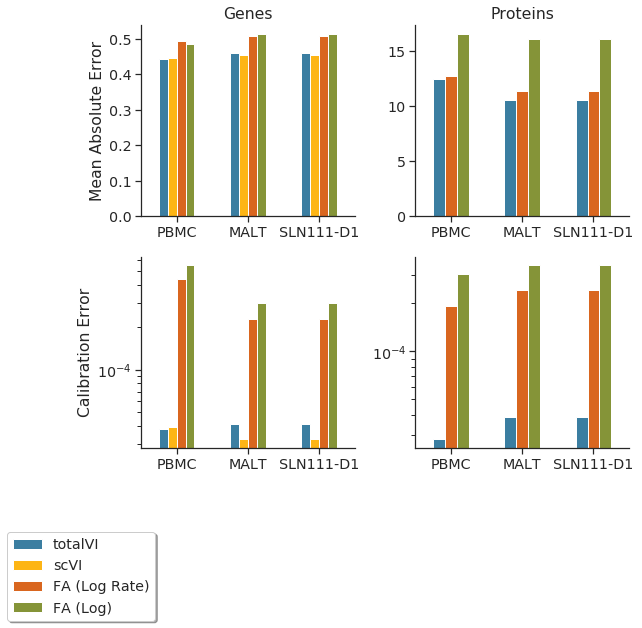

In [17]:
ppc_bar_plots(key="mean_ae")
plt.tight_layout()
plt.savefig("figures/mae_cal.pdf")

In [18]:
for p in ppc_helds:
    del p

In [19]:
# del p for p in ppc_helds
ppc_fulls = [ppc_full_pbmc, ppc_full_malt, ppc_full_sln]
for p, dataset in zip(ppc_fulls, datasets):
    p.store_fa_samples(
        p.raw_counts.todense(),
        np.arange(len(dataset)),
        np.arange(len(dataset)),
        n_components=vae_pbmc.n_latent,
        normalization="log",
        key="FA"
    )
    p.store_fa_samples(
        p.raw_counts.todense(),
        np.arange(len(dataset)),
        np.arange(len(dataset)),
        n_components=vae_pbmc.n_latent,
        normalization="log_rate",
        key="FA"
    )

In [20]:
# Runtime warning is when samples have all zeros, we consider this as 0 cv
for p in ppc_fulls:
    p.coeff_of_variation(cell_wise=False)

../utils/totalppc.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.std(samples, axis=axis) / np.mean(samples, axis=axis), axis=-1


In [21]:
cv_gene_mae_pbmc, cv_gene_mae_malt, cv_gene_mae_sln = {}, {}, {}
cv_pro_mae_pbmc, cv_pro_mae_malt, cv_pro_mae_sln = {}, {}, {}
cv_gene_maes = [cv_gene_mae_pbmc, cv_gene_mae_malt, cv_gene_mae_sln]
cv_pro_maes = [cv_pro_mae_pbmc, cv_pro_mae_malt, cv_pro_mae_sln]

for p, dataset, cv_gene_mae, cv_pro_mae in zip(ppc_fulls, datasets, cv_gene_maes, cv_pro_maes):
    for m, samples in p.posterior_predictive_samples.items():
        cv_gene_mae[m] = [np.mean(
            np.abs(
                p.metrics["cv_gene"][m].iloc[: dataset.nb_genes]
                - p.metrics["cv_gene"]["raw"].iloc[: dataset.nb_genes]
            )
        )]
        cv_pro_mae[m] = [np.mean(
            np.abs(
                p.metrics["cv_gene"][m].iloc[dataset.nb_genes:]
                - p.metrics["cv_gene"]["raw"].iloc[dataset.nb_genes:]
            )
        )]
    p.metrics["cv_gene_mae"] = pd.DataFrame.from_dict(cv_gene_mae)
    p.metrics["cv_pro_mae"] = pd.DataFrame.from_dict(cv_pro_mae)

In [22]:
(p.metrics["cv_gene_mae"].iloc[: dataset.nb_genes] == 0).sum(axis=0)

totalVI          0
scVI             0
FA (Log)         0
FA (Log Rate)    0
dtype: int64

[[0.71 0.86 7.9  7.19]]
[['0.71' '0.86' '7.9' '7.19' '--']]
[[ 1.39  1.91 12.1  10.56]]
[['1.39' '1.91' '12.1' '10.56' '--']]
[[1.03 1.15 8.77 8.19]]
[['1.03' '1.15' '8.77' '8.19' '--']]


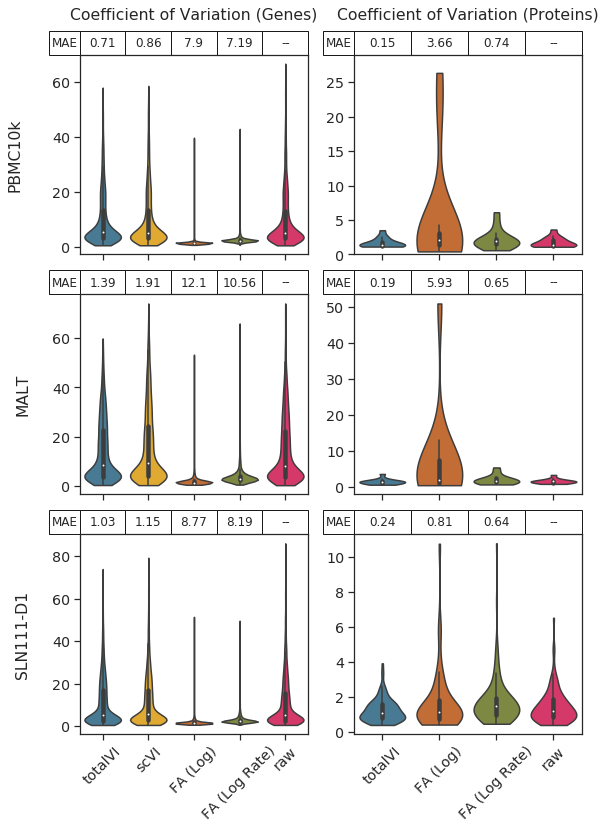

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(9, 12.5), sharex=False)
inds = [0, 2, 4]
for i, p, dataset in zip(inds, ppc_fulls, datasets):
    gene_table = np.round(p.metrics["cv_gene_mae"].values, 2)
    print(gene_table)
    gene_table = np.concatenate([gene_table, np.array(["--"]).reshape(1, 1)], axis=1)
    print(gene_table)
    pro_table = np.round(p.metrics["cv_pro_mae"].drop(["scVI"], axis=1).values, 2)
    pro_table = np.concatenate([pro_table, np.array(["--"]).reshape(1, 1)], axis=1)
    sns.set_palette(colors)
    sns.violinplot(
        data=p.metrics["cv_gene"].iloc[: dataset.nb_genes],
        ax=ax.flat[i],
        cut=0,
        scale="count",
        order=["totalVI", "scVI", "FA (Log)", "FA (Log Rate)", "raw"]
    )
    the_table = ax.flat[i].table(
        cellText=gene_table, rowLabels=["MAE"], loc="top", cellLoc="center"
    )
    the_table.scale(1, 2)
    the_table.set_fontsize(12)
    
    sns.set_palette(colors_3)
    sns.violinplot(
        data=p.metrics["cv_gene"].iloc[dataset.nb_genes :],
        ax=ax.flat[i + 1],
        cut=0,
        scale="count",
        order=["totalVI", "FA (Log)", "FA (Log Rate)", "raw"]
    )
    the_table = ax.flat[i + 1].table(
        cellText=pro_table,
        loc="top",
        cellLoc="center",
        rowLabels=["MAE"],
    )
    the_table.scale(1, 2)
    the_table.set_fontsize(12)

title = ax.flat[0].set_title("Coefficient of Variation (Genes)")
title.set_position([0.5, 1.15])
title = ax.flat[1].set_title("Coefficient of Variation (Proteins)")
title.set_position([0.5, 1.15])
ax.flat[1].set_ylim(0, 29)
ax.flat[0].set_xticklabels([])
ax.flat[1].set_xticklabels([])
ax.flat[2].set_xticklabels([])
ax.flat[3].set_xticklabels([])
ax.flat[4].tick_params(axis="x", rotation=45)
ax.flat[5].tick_params(axis="x", rotation=45)
ax.flat[0].set_ylabel("PBMC10k", labelpad=30)
ax.flat[2].set_ylabel("MALT", labelpad=22)
ax.flat[4].set_ylabel("SLN111-D1", labelpad=22)
# sns.despine()

# plt.tight_layout()
plt.savefig("figures/violins_cv.pdf", bbox_inches="tight")

### Reconstruction Loss

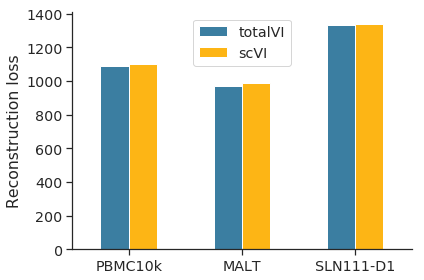

In [24]:
trainers = [trainer_pbmc, trainer_malt, trainer_sln]
scvi_trainers = [scvi_trainer_pbmc, scvi_trainer_malt, scvi_trainer_sln]

dnames = ["PBMC10k", "MALT", "SLN111-D1"]
reconst_df = pd.DataFrame(index=dnames, columns=["totalVI", "scVI"])

for dn, t, st in zip(dnames, trainers, scvi_trainers):
    reconst_df.loc[dn, "totalVI"] = t.validation_set.reconstruction_error(mode="gene")
    reconst_df.loc[dn, "scVI"] = st.validation_set.reconstruction_error()

fig, ax = plt.subplots(1, 1)
reconst_df.plot(kind="bar", color=colors, ax=ax)
sns.despine()
ax.set_ylabel("Reconstruction loss")
ax.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.savefig("figures/rec_error.pdf")